In [1]:
import sys
import os
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import rcParams, cycler
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import xarray as xr
import geopandas as gpd
import rioxarray
from xeofs.xarray import EOF
import gc
import collections
import statsmodels.api as sm
import scipy
from sklearn.metrics import mean_squared_error
from math import sqrt
from itertools import product
import pyproj
from shapely.geometry import mapping
import pandas as pd

In [2]:
import seaborn as sns
sns.set_theme(style="whitegrid")

plt.rcParams.update({'font.size': 18})
plt.rc('font', family='sans-serif') 
plt.rc('font', serif='Helvetica Neue')

In [3]:
# Define project repo path
inDirName = '/Users/smurugan9/research/aislens/aislens_emulation/'

# DATA FILE PATHS

# Data containing regridded flux and SSH for 150 years
regriddedFluxSSH_filepath = 'data/interim/RegriddedFluxSSH.nc'

# File contains all defined ice shelves
iceShelvesShape_filepath = 'data/interim/iceShelves.geojson'

# Folder for output figures
figures_folderpath = 'reports/figures/' 

interim_data_folder = 'data/interim/'
flux_dedrafted_data_path = 'dedrafted_flux_IMBIE/'
randomized_realizations_path = 'randomized_realizations/'
flux_dedrafted_iceshelves_data_path = 'iceshelves_dedrafted_flux/'
reconstructions_neofs_path = 'reconstructions_neofs/'
cise_file_path = 'cise_data/'

In [ ]:
# Read geoJSON region feature file as GeoDataFrame
iceshelvesmask = gpd.read_file(inDirName + iceShelvesShape_filepath)
# Convert to south polar stereographic projection
icems = iceshelvesmask.to_crs({'init': 'epsg:3031'});
crs = ccrs.SouthPolarStereo();

In [5]:
# Input data files
regridded_data = xr.open_dataset(inDirName+regriddedFluxSSH_filepath)
flux = regridded_data.timeMonthly_avg_landIceFreshwaterFlux
ssh = regridded_data.timeMonthly_avg_ssh

flux_clean = xr.open_dataset(inDirName+interim_data_folder+'flux_clean')
flux_clean = flux_clean.timeMonthly_avg_landIceFreshwaterFlux

In [6]:
flux_clean_mean = flux_clean.mean('time')
flux_clean_std = flux_clean.std('time')

In [10]:
flux_clean_demeaned = flux_clean - flux_clean_mean
flux_clean_standardized = flux_clean_demeaned/flux_clean_std

In [87]:
flux_clean_demeaned_ts = flux_clean_demeaned.mean(['y','x'])

In [14]:
flux_clean_standardized_ts = flux_clean_standardized.mean(['y','x'])

Text(0.5, 0, 'Time (months)')

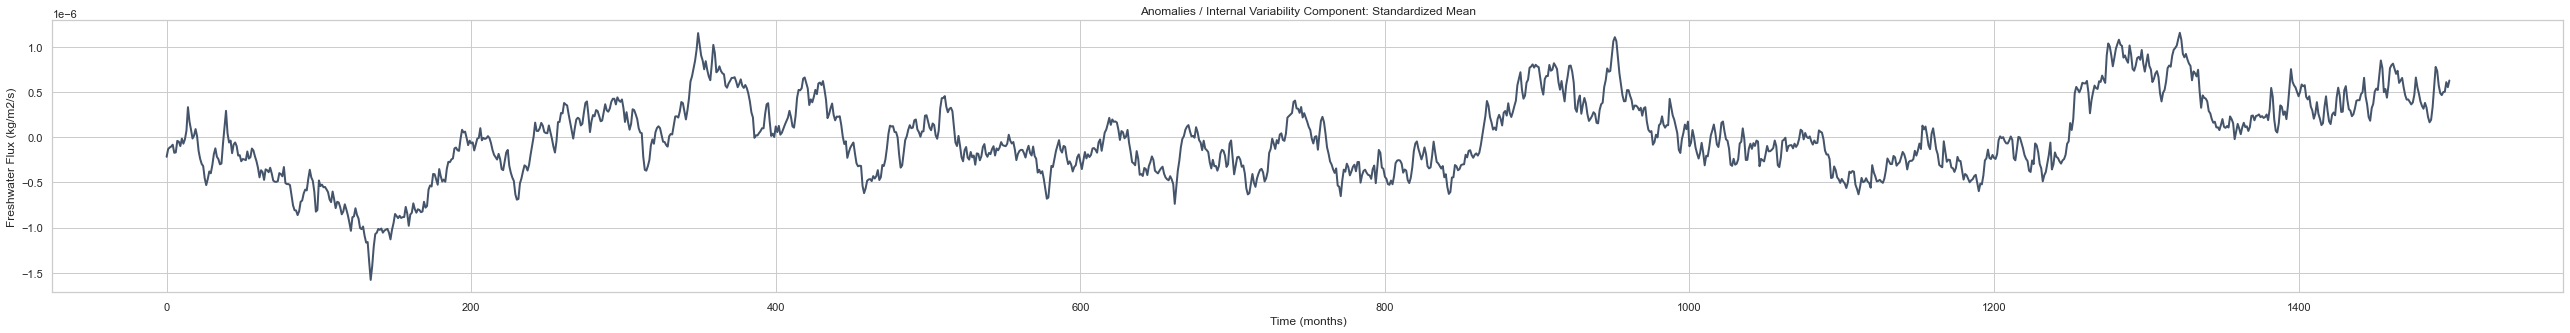

In [91]:
# Figure: Anomalies / Internal Variability Component of Input Data: Temporal Variability (Standardized Mean)
plt.figure(figsize=(45,5))
#plt.plot(flux_anm_ts)
#plt.plot(flux_clean_standardized_ts[:], color = '#44546A', linewidth=2)
plt.plot(flux_clean_demeaned_ts[:], color = '#44546A', linewidth=2)
plt.title('Anomalies / Internal Variability Component: Standardized Mean')
plt.ylabel('Freshwater Flux (kg/m2/s)')
plt.xlabel('Time (months)')

## Spatial Decomposition: EOFs

In [17]:
%%time
model = EOF(flux_clean_standardized)
model.solve()
eofs = model.eofs()
pcs = model.pcs()
nmodes = model.n_modes
varexpl = model.explained_variance_ratio()

CPU times: user 1min 4s, sys: 26.3 s, total: 1min 30s
Wall time: 32.3 s


Text(0.5, 1.0, 'Total Relative Power of first 100 EOFs: 84.39104280815239')

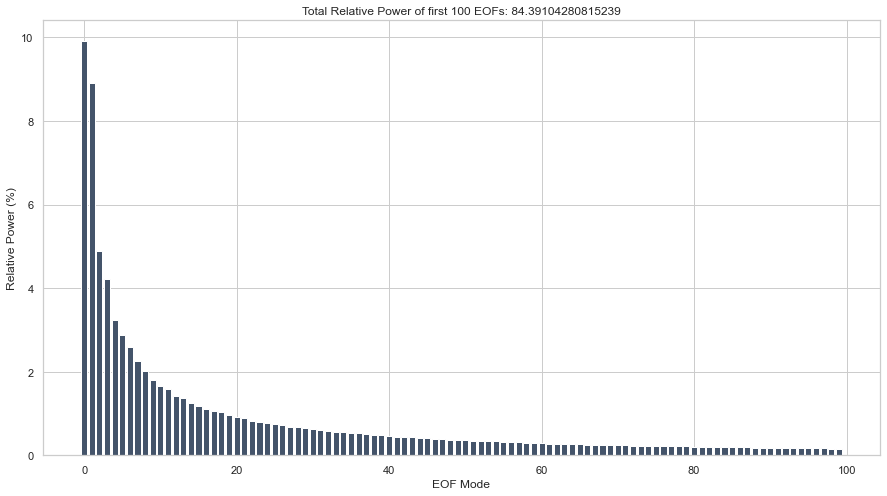

In [25]:
# Figure: Relative power of m EOFs

m = 100
plt.figure(figsize=(15,8))
plt.bar(range(m),varexpl[:m]*100, color='#44546A')
plt.ylabel('Relative Power (%)')
plt.xlabel('EOF Mode')
plt.title('Total Relative Power of first {} EOFs: {}'.format(m,varexpl[:m].sum().values*100))

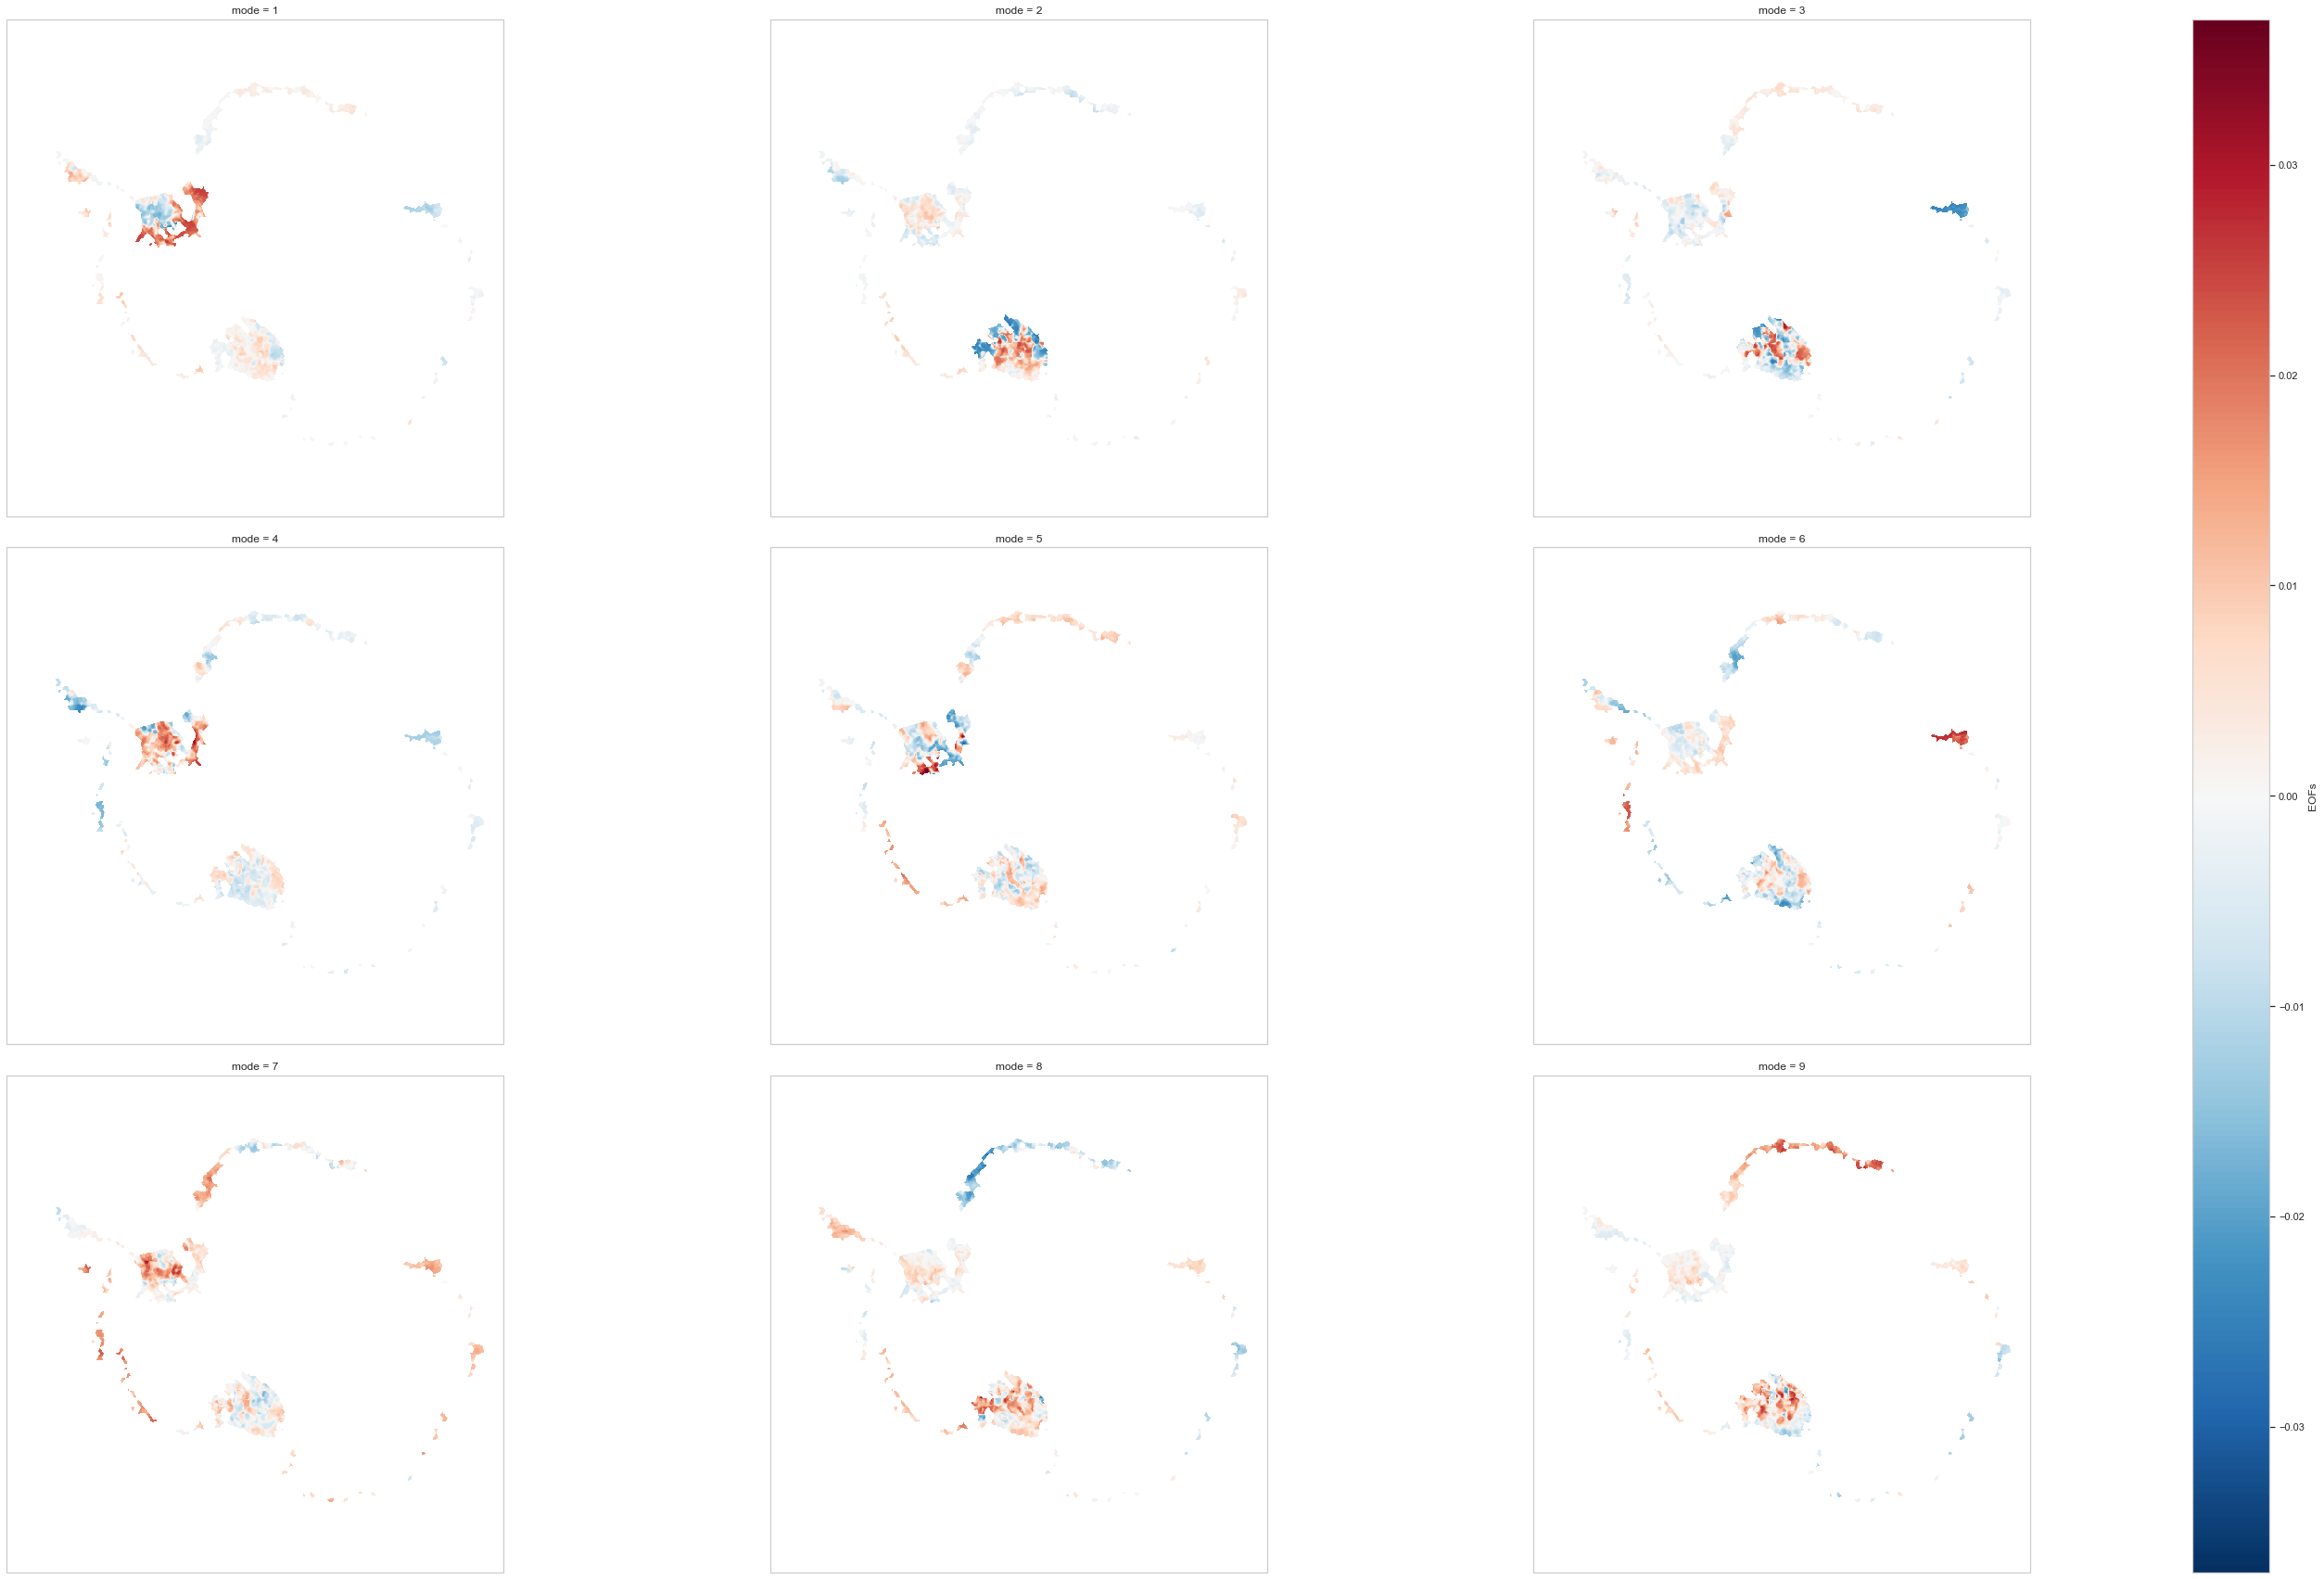

In [26]:
# Figure: Dominant EOF modes
fg = eofs[:,:,0:9].plot(aspect=2,
                            size=8,
                            col="mode", 
                            col_wrap=3,
                            subplot_kws=dict(projection=ccrs.SouthPolarStereo()))

# TODO: Redefine vmax, vmin 

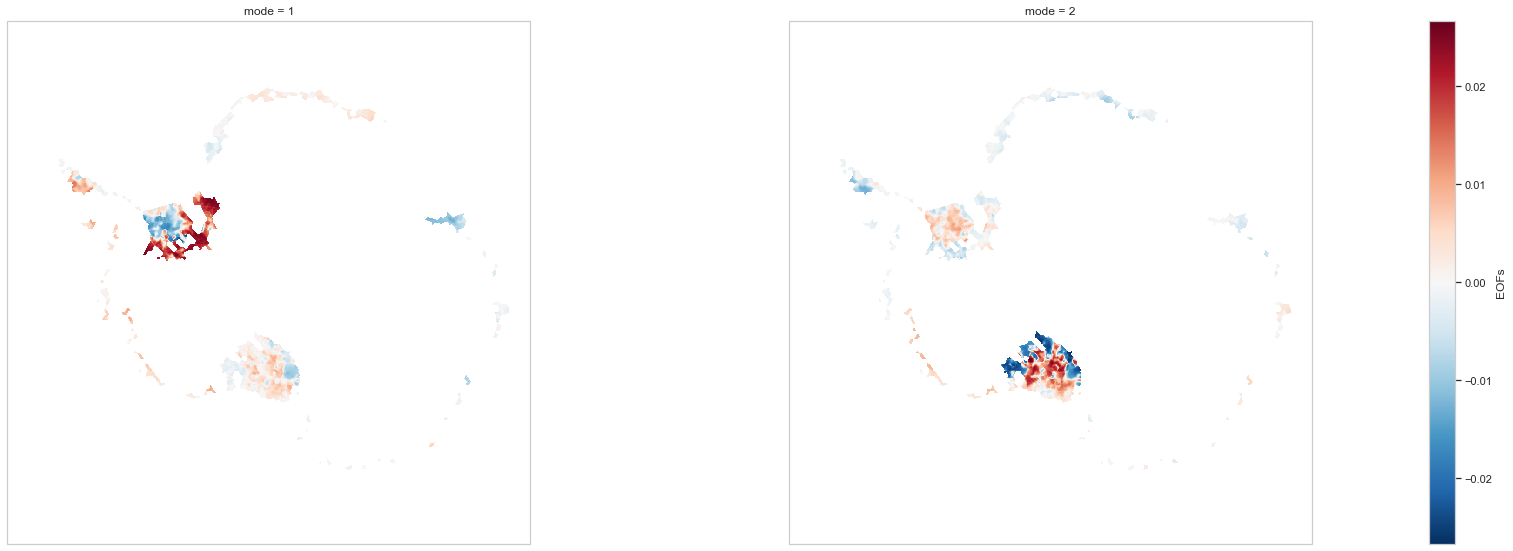

In [53]:
# Figure: Dominant EOF modes
fg = eofs[:,:,0:2].plot(aspect=2,
                            size=8,
                            col="mode", 
                            col_wrap=2,
                            subplot_kws=dict(projection=ccrs.SouthPolarStereo()))

# TODO: Redefine vmax, vmin 

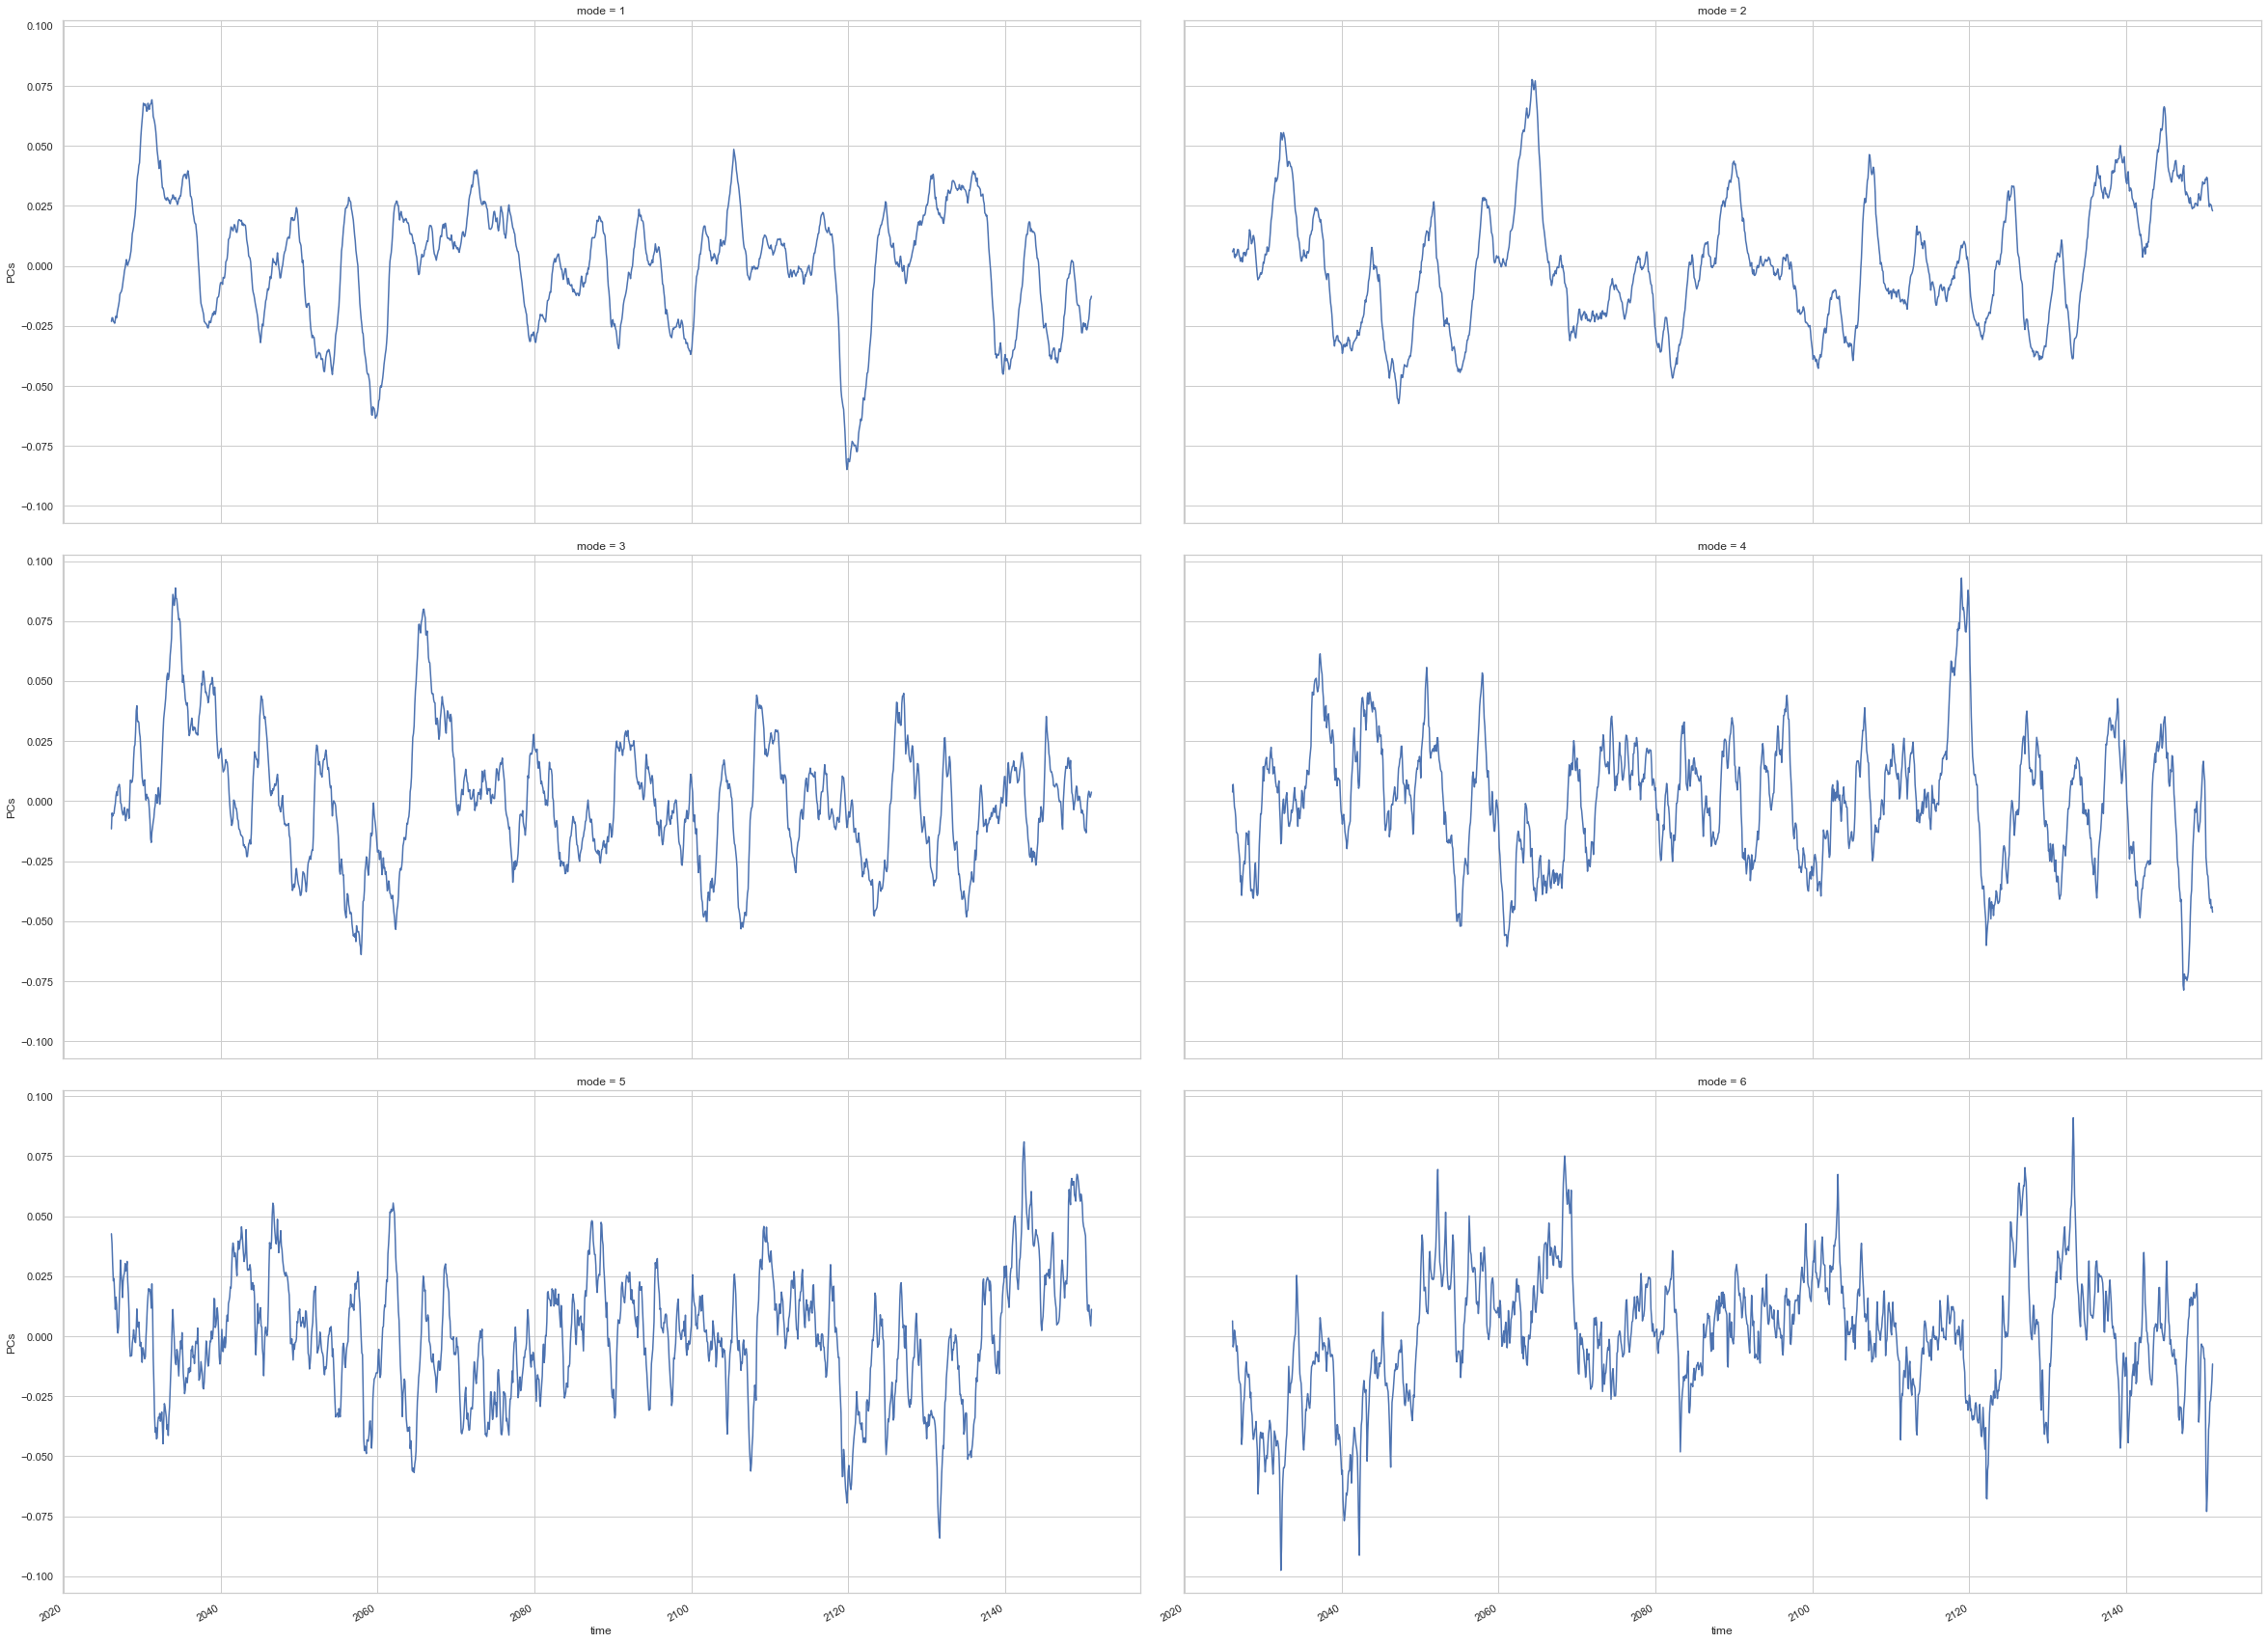

In [110]:
# Figure: Dominant EOF modes
fg = pcs[:,0:6].plot(aspect=2,size=8,col="mode",col_wrap=2)

# TODO: Redefine vmax, vmin 

## Fourier Phase Randomization

In [ ]:
%%time
##############################
# FOURIER PHASE RANDOMIZATION 
##############################

# Define number of random Fourier realizations
n_realizations = 3
t_length = pcs.shape[0]

# xeofs_pcs[:,i] when using PCA outputs
new_fl = np.empty((n_realizations,pcs.shape[0],pcs.shape[1]))

# Time limits for plotting
t1 = 0
tf = int(t_length/2)

for i in range(n_realizations):
    for m in range(nmodes):
        fl = pcs[:,m] # fluxpcs[:,i] when using PCA outputs
        fl_fourier = np.fft.rfft(fl)
        random_phases = np.exp(np.random.uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j)
        fl_fourier_new = fl_fourier*random_phases
        new_fl[i,:,m] = np.fft.irfft(fl_fourier_new)
        print('calculated ifft for realization {}, mode: {}'.format(i,m))

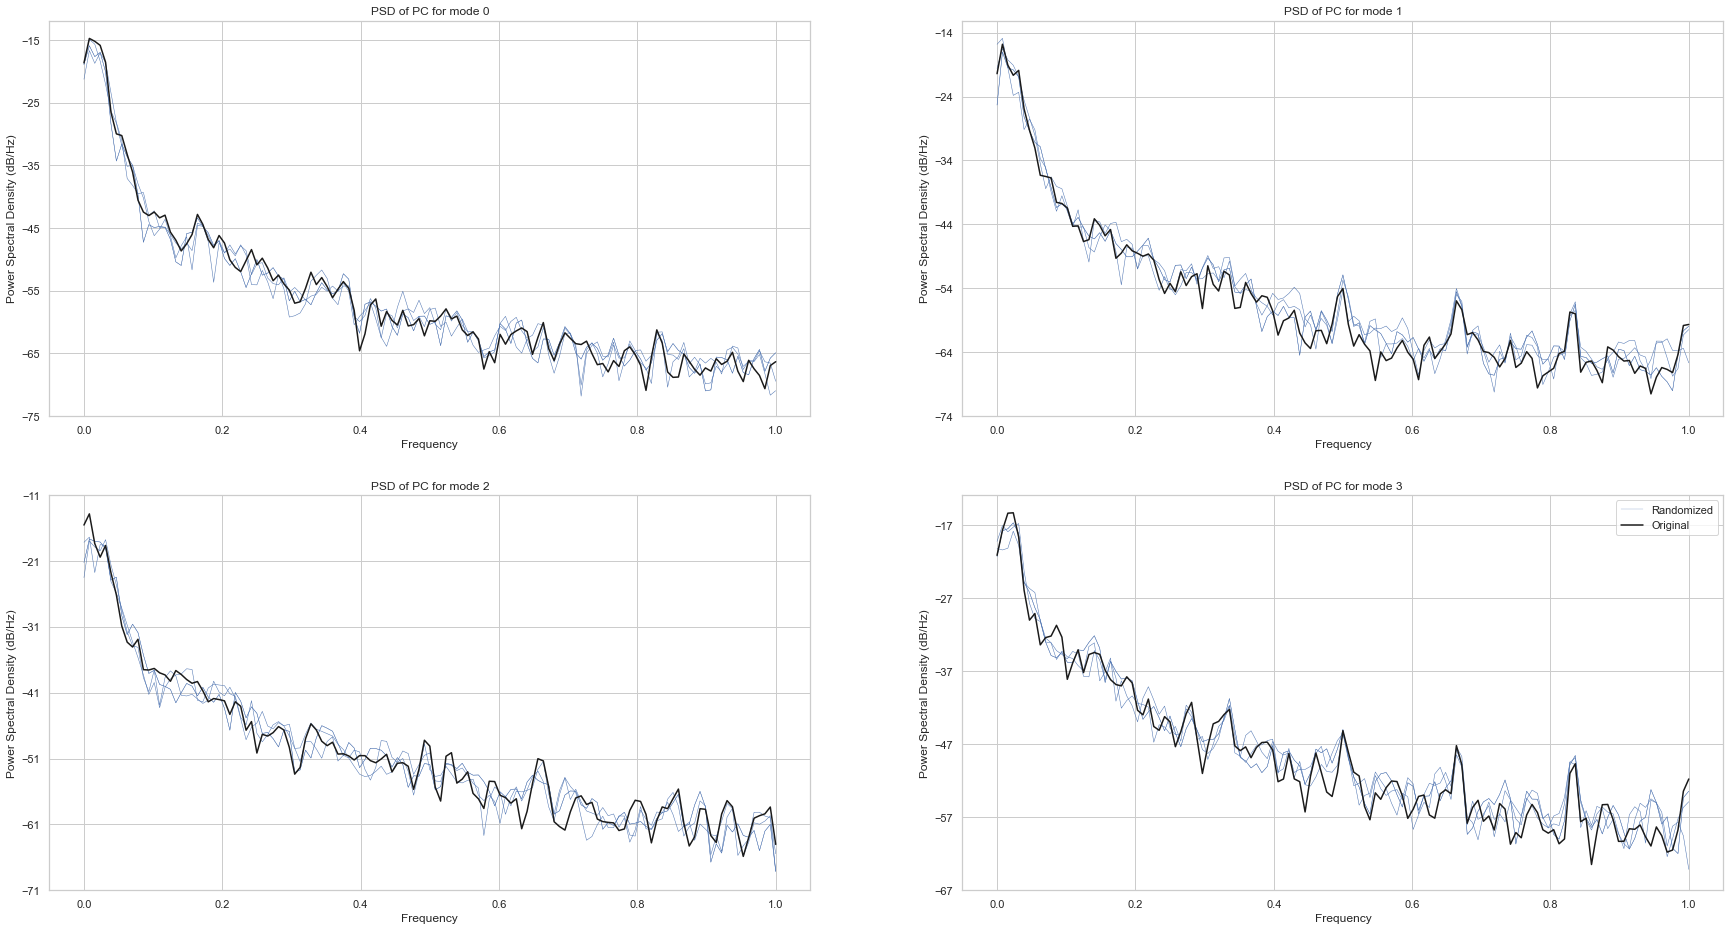

In [30]:
# FIGURE (FOR TESTING)

fig, axs = plt.subplots(2,2,figsize=(30,16))
axs=axs.ravel()

for mode_m in range(0,4):
    for i in range(0,3):
        axs[mode_m].psd(new_fl[i,:,mode_m],color='b', linewidth=0.5)
    axs[mode_m].psd(new_fl[0,:,mode_m],color='b', linewidth=0.25,label='Randomized')
    axs[mode_m].psd(pcs[:,mode_m],color='k', linewidth=1.5,label='Original')
    axs[mode_m].set_title('PSD of PC for mode {}'.format(mode_m))
plt.legend()

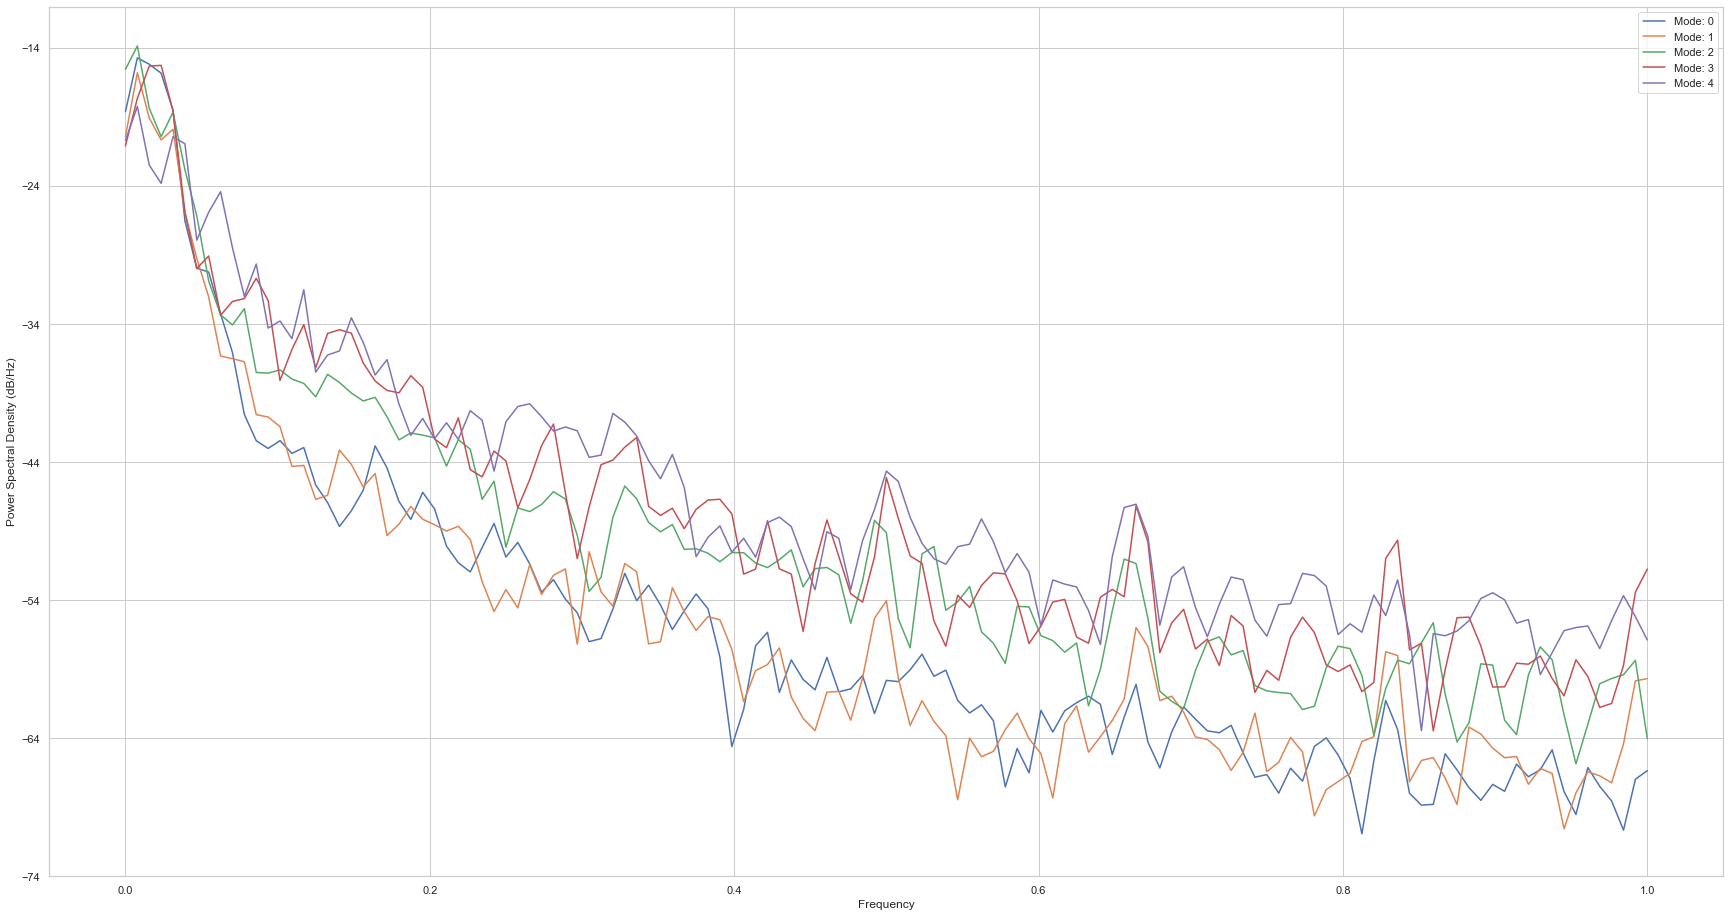

In [81]:
# FIGURE (FOR TESTING)

plt.figure(figsize=(30,16))

for mode_m in range(0,5):
    plt.psd(pcs[:,mode_m], linewidth=1.5,label='Mode: {}'.format(mode_m))
plt.legend()

# Plot moving average / smooothened PSDs

In [31]:
#modified to not return f - in calculation of RMSE, only Px required
def psd_calc_grid(data,y,x):
    f, Px = scipy.signal.welch(data[:,y,x])
    return Px

In [32]:
def time_series(clipped_data):
    clipped_ts = clipped_data.sum(['y','x'])
    return clipped_ts

In [33]:
# Reconstruct flux dataset using phase randomized PCs
# This section is to be called iteratively for ensemble runs with multiple realizations
# This method also takes 'modes' as a parameter: 
# which is used to reconstruct dataset with different number of selected modes

def generate_data(n_realization,mode,mode_skip):
    flux_reconstr = model.reconstruct_randomized_X(new_fl[n_realization],slice(1,mode,mode_skip))
    #flux_reconstr = flux_reconstr.dropna('time',how='all')
    #flux_reconstr = flux_reconstr.dropna('y',how='all')
    #flux_reconstr = flux_reconstr.dropna('x',how='all')
    #flux_reconstr = flux_reconstr.drop("month")
    return flux_reconstr

In [34]:
def clip_data(total_data, basin):
    clipped_data = total_data.rio.clip(icems.loc[[basin],'geometry'].apply(mapping))
    #clipped_data = clipped_data.dropna('time',how='all')
    #clipped_data = clipped_data.dropna('y',how='all')
    #clipped_data = clipped_data.dropna('x',how='all')
    clipped_data = clipped_data.drop("month")
    return clipped_data

## Ensemble Member Data Generation

In [56]:
# Generate dataset realizations
for i in range(n_realizations):
    flux_reconstr = generate_data(i, 100, 1)
    flux_reconstr = (flux_reconstr*flux_clean_std) + flux_clean_mean
    flux_reconstr.to_netcdf(inDirName+interim_data_folder+cise_file_path+"flux_gen_100_{}.nc".format(i))
    del flux_reconstr_standardized, flux_reconstr
    gc.collect()
    print('reconstructed realization # {}'.format(i))

reconstructed realization # 0
reconstructed realization # 1
reconstructed realization # 2


In [36]:
basins = np.array((34,55,114,103,104,105))

In [57]:
# change file name for other realizations
flux_reconstr0 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+'flux_gen_100_0.nc')
flux_reconstr0 = flux_reconstr0.__xarray_dataarray_variable__

flux_reconstr1 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+'flux_gen_100_1.nc')
flux_reconstr1 = flux_reconstr1.__xarray_dataarray_variable__

flux_reconstr2 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+'flux_gen_100_2.nc')
flux_reconstr2 = flux_reconstr2.__xarray_dataarray_variable__

In [58]:
for basin in basins:
    orig = clip_data(flux_clean, basin)
    rec0 = clip_data(flux_reconstr0, basin)
    rec1 = clip_data(flux_reconstr1, basin)
    rec2 = clip_data(flux_reconstr2, basin)
    orig.to_netcdf(inDirName+interim_data_folder+cise_file_path+"orig_100_{}".format(basin))
    rec0.to_netcdf(inDirName+interim_data_folder+cise_file_path+"rec0_100_{}".format(basin))
    rec1.to_netcdf(inDirName+interim_data_folder+cise_file_path+"rec1_100_{}".format(basin))
    rec2.to_netcdf(inDirName+interim_data_folder+cise_file_path+"rec2_100_{}".format(basin))
    del orig, rec0, rec1, rec2
    gc.collect()

In [59]:
# Amery 34
orig_34 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"orig_100_34")
rec0_34 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec0_100_34")
rec1_34 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec1_100_34")
rec2_34 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec2_100_34")

# Filchner 55
orig_55 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"orig_100_55")
rec0_55 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec0_100_55")
rec1_55 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec1_100_55")
rec2_55 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec2_100_55")

# Thwaites 114
orig_114 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"orig_100_114")
rec0_114 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec0_100_114")
rec1_114 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec1_100_114")
rec2_114 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec2_100_114")

# Ronne 103
orig_103 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"orig_100_103")
rec0_103 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec0_100_103")
rec1_103 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec1_100_103")
rec2_103 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec2_100_103")

# Western Ross 104
orig_104 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"orig_100_104")
rec0_104 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec0_100_104")
rec1_104 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec1_100_104")
rec2_104 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec2_100_104")

# Eastern Ross 105
orig_105 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"orig_100_105")
rec0_105 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec0_100_105")
rec1_105 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec1_100_105")
rec2_105 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec2_100_105")

In [70]:
# Amery 34
orig_34 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"orig_34")
rec0_34 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec0_34")
rec1_34 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec1_34")
rec2_34 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec2_34")

# Filchner 55
orig_55 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"orig_55")
rec0_55 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec0_55")
rec1_55 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec1_55")
rec2_55 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec2_55")

# Thwaites 114
orig_114 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"orig_114")
rec0_114 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec0_114")
rec1_114 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec1_114")
rec2_114 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec2_114")

# Ronne 103
orig_103 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"orig_103")
rec0_103 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec0_103")
rec1_103 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec1_103")
rec2_103 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec2_103")

# Western Ross 104
orig_104 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"orig_104")
rec0_104 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec0_104")
rec1_104 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec1_104")
rec2_104 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec2_104")

# Eastern Ross 105
orig_105 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"orig_105")
rec0_105 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec0_105")
rec1_105 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec1_105")
rec2_105 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec2_105")

In [71]:
# Amery 
orig_34_ts = time_series(orig_34)
rec0_34_ts = time_series(rec0_34)
rec1_34_ts = time_series(rec1_34)
rec2_34_ts = time_series(rec2_34)

# Filchner 
orig_55_ts = time_series(orig_55)
rec0_55_ts = time_series(rec0_55)
rec1_55_ts = time_series(rec1_55)
rec2_55_ts = time_series(rec2_55)

# Thwaites 
orig_114_ts = time_series(orig_114)
rec0_114_ts = time_series(rec0_114)
rec1_114_ts = time_series(rec1_114)
rec2_114_ts = time_series(rec2_114)

# Ronne 
orig_103_ts = time_series(orig_103)
rec0_103_ts = time_series(rec0_103)
rec1_103_ts = time_series(rec1_103)
rec2_103_ts = time_series(rec2_103)

# Western Ross 
orig_104_ts = time_series(orig_104)
rec0_104_ts = time_series(rec0_104)
rec1_104_ts = time_series(rec1_104)
rec2_104_ts = time_series(rec2_104)

# Eastern Ross 
orig_105_ts = time_series(orig_105)
rec0_105_ts = time_series(rec0_105)
rec1_105_ts = time_series(rec1_105)
rec2_105_ts = time_series(rec2_105)

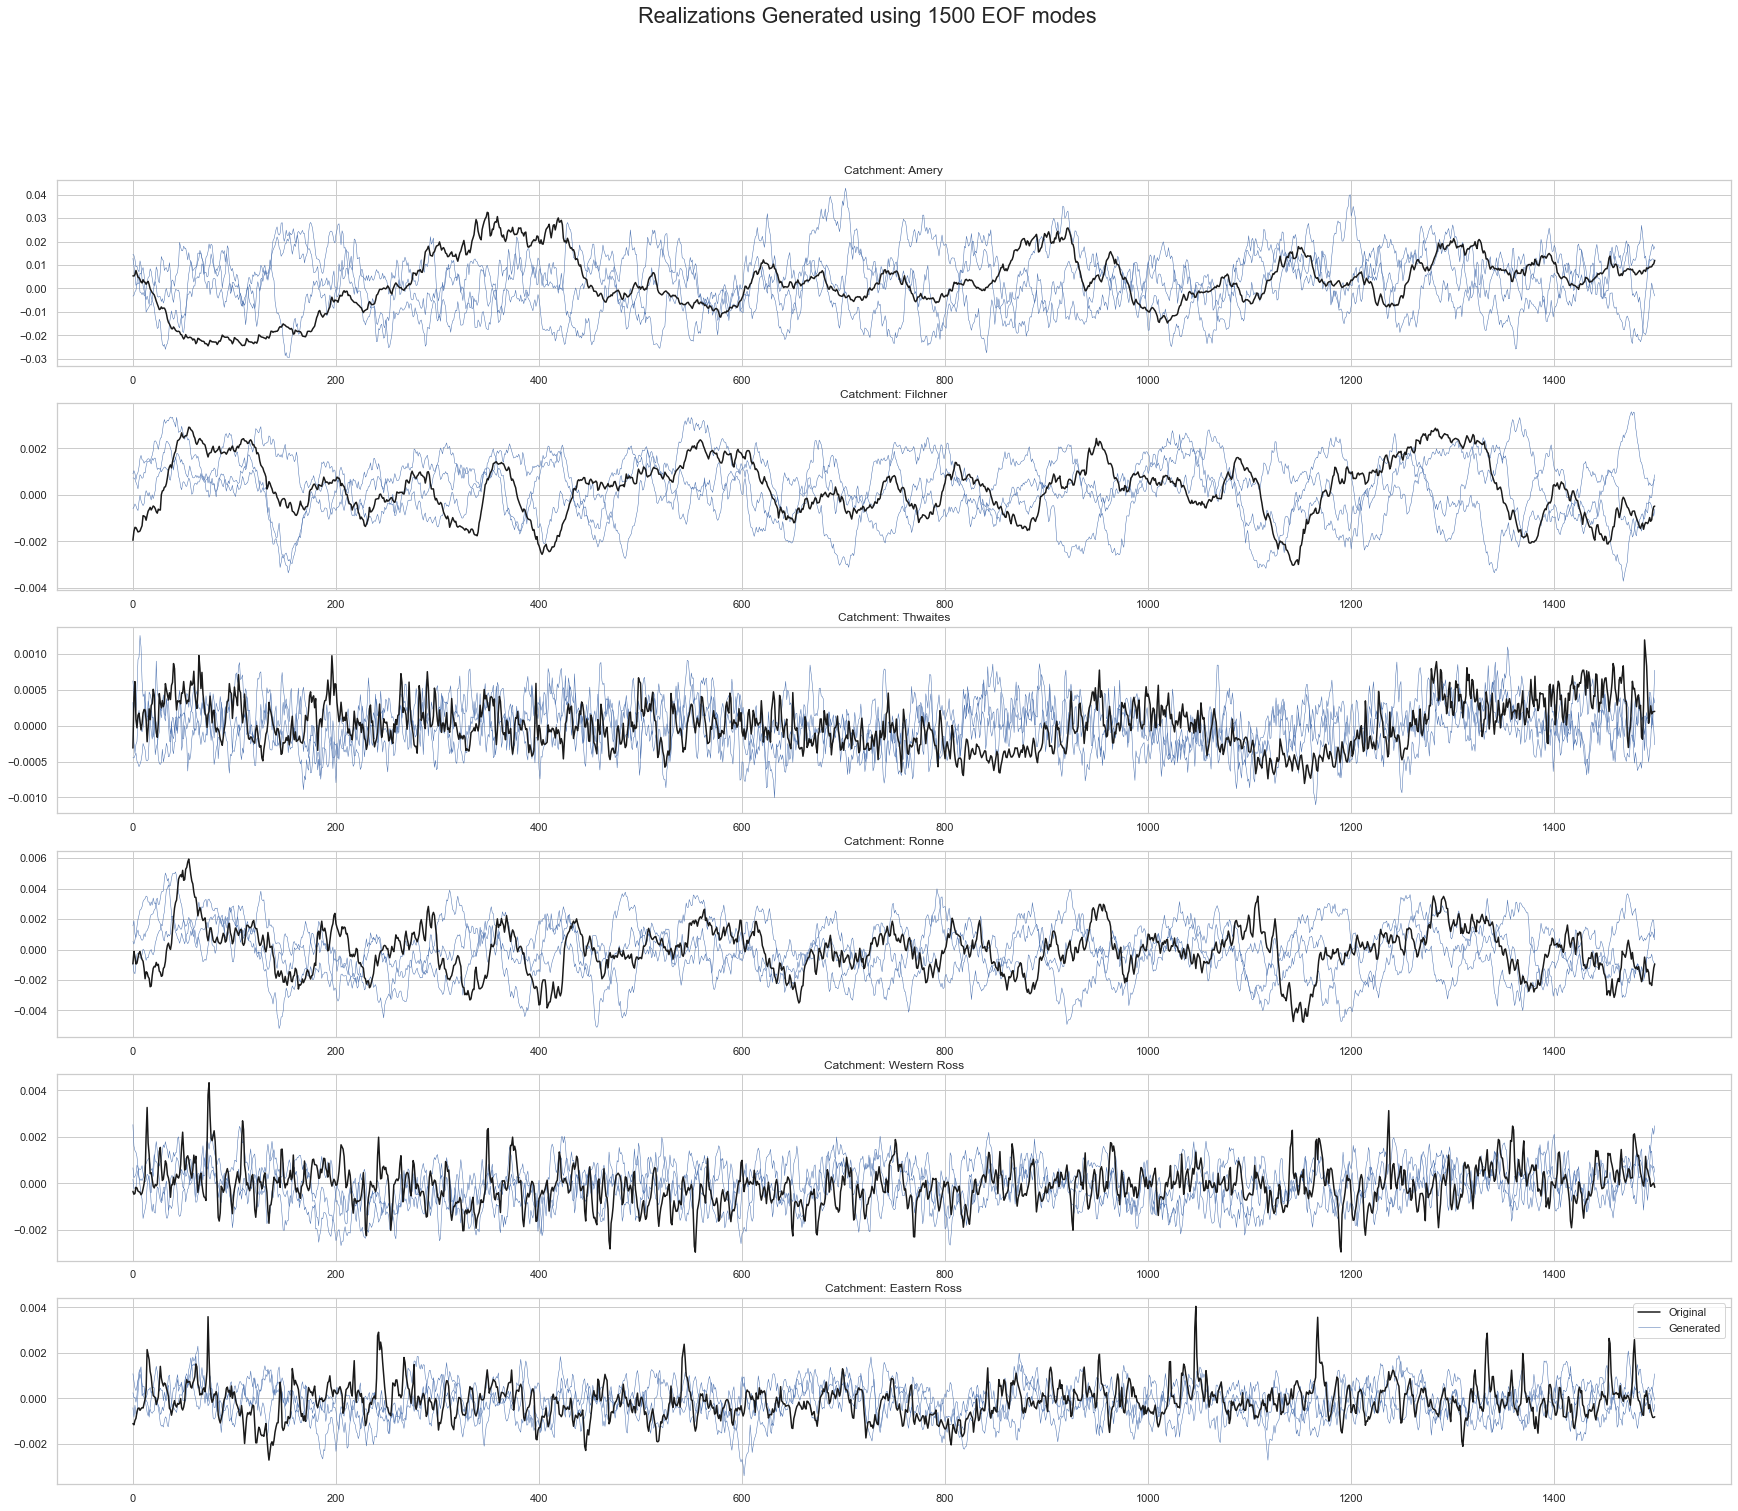

In [72]:
fig, axs = plt.subplots(6,1,figsize=(30,24))
axs=axs.ravel()

axs[0].plot(orig_34_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[0].plot(rec0_34_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[0].plot(rec1_34_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[0].plot(rec2_34_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[0].set_title('Catchment: Amery');

axs[1].plot(orig_55_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[1].plot(rec0_55_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[1].plot(rec1_55_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[1].plot(rec2_55_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[1].set_title('Catchment: Filchner');

axs[2].plot(orig_114_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[2].plot(rec0_114_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[2].plot(rec1_114_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[2].plot(rec2_114_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[2].set_title('Catchment: Thwaites');

axs[3].plot(orig_103_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[3].plot(rec0_103_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[3].plot(rec1_103_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[3].plot(rec2_103_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[3].set_title('Catchment: Ronne');

axs[4].plot(orig_104_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[4].plot(rec0_104_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[4].plot(rec1_104_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[4].plot(rec2_104_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[4].set_title('Catchment: Western Ross');

axs[5].plot(orig_105_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[5].plot(rec0_105_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[5].plot(rec1_105_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[5].plot(rec2_105_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[5].set_title('Catchment: Eastern Ross');
plt.legend()

plt.suptitle('Realizations Generated using 1500 EOF modes');

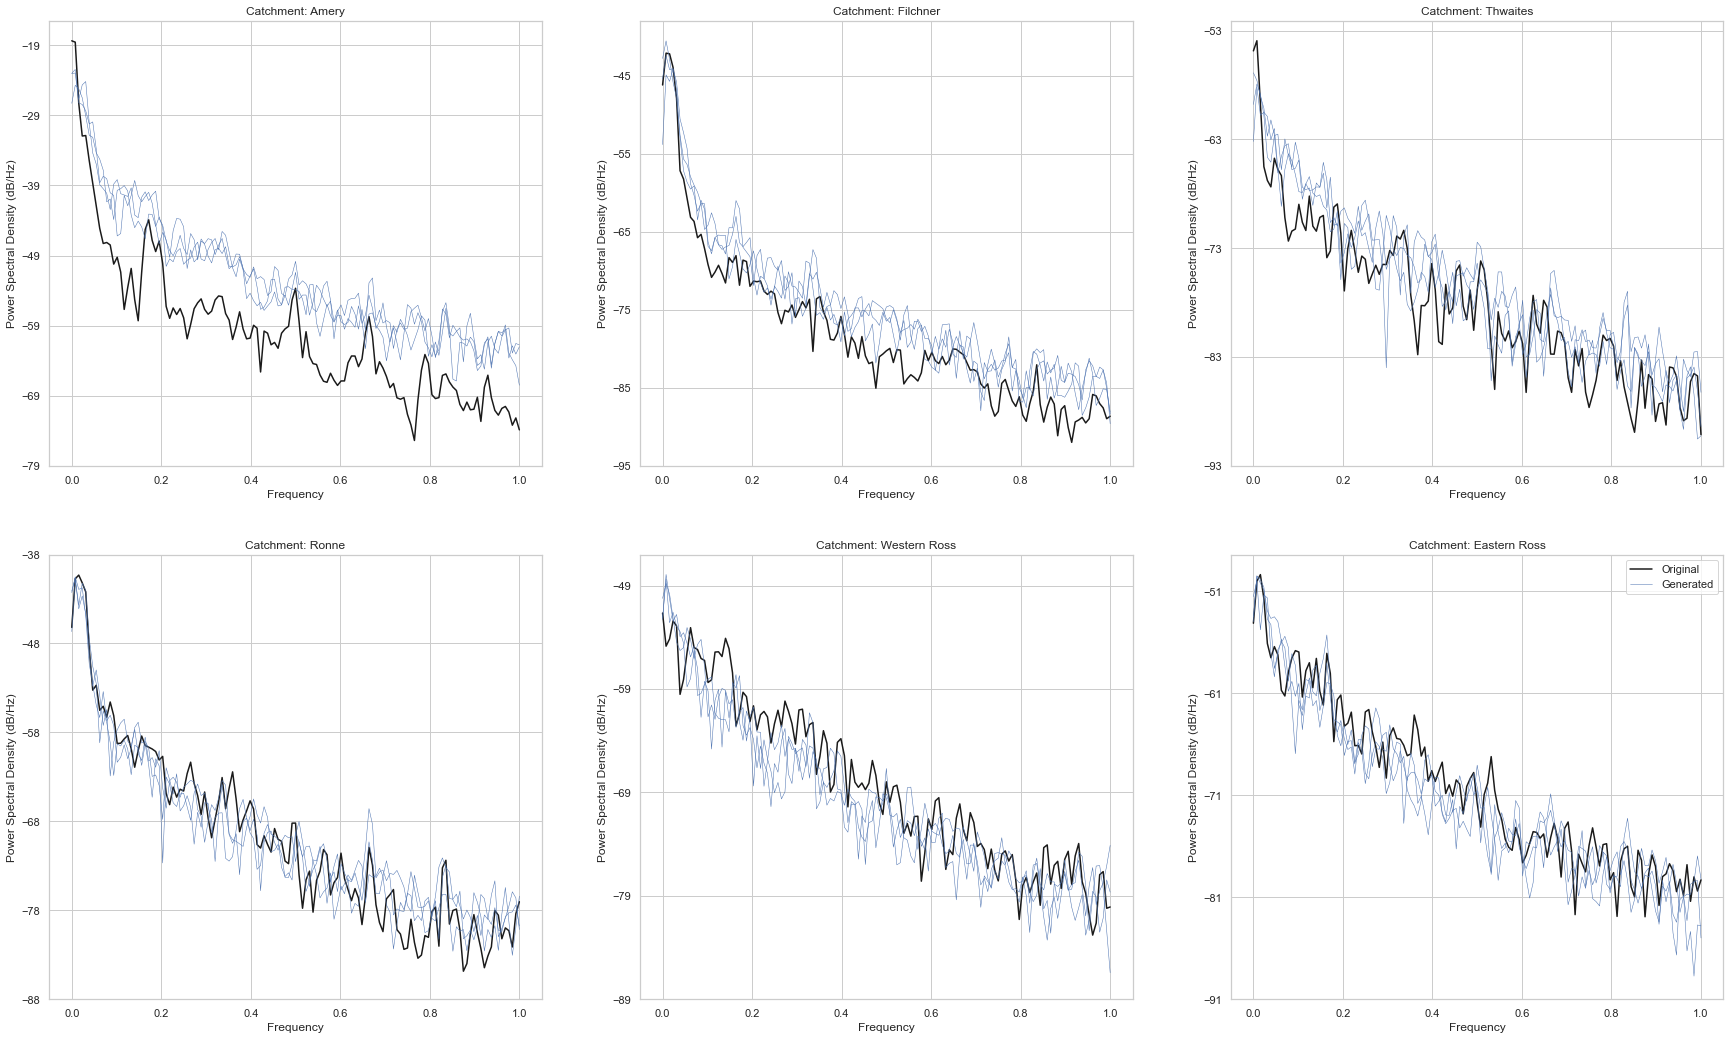

In [83]:
fig, axs = plt.subplots(2,3,figsize=(30,18))
axs=axs.ravel()

axs[0].psd(orig_34_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original');
axs[0].psd(rec0_34_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[0].psd(rec1_34_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[0].psd(rec2_34_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[0].set_title('Catchment: Amery');

axs[1].psd(orig_55_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original');
axs[1].psd(rec0_55_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[1].psd(rec1_55_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[1].psd(rec2_55_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[1].set_title('Catchment: Filchner');

axs[2].psd(orig_114_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original');
axs[2].psd(rec0_114_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[2].psd(rec1_114_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[2].psd(rec2_114_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[2].set_title('Catchment: Thwaites');

axs[3].psd(orig_103_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original');
axs[3].psd(rec0_103_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[3].psd(rec1_103_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[3].psd(rec2_103_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[3].set_title('Catchment: Ronne');

axs[4].psd(orig_104_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original');
axs[4].psd(rec0_104_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[4].psd(rec1_104_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[4].psd(rec2_104_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[4].set_title('Catchment: Western Ross');

axs[5].psd(orig_105_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original');
axs[5].psd(rec0_105_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[5].psd(rec1_105_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[5].psd(rec2_105_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[5].set_title('Catchment: Eastern Ross');
plt.legend()

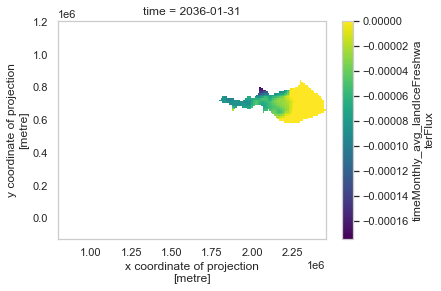

In [82]:
orig_34.timeMonthly_avg_landIceFreshwaterFlux[120].plot()

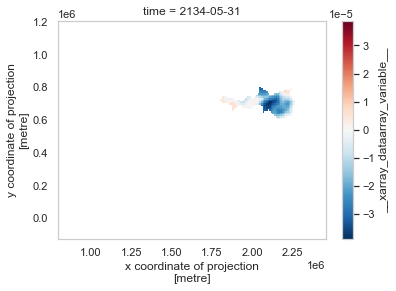

In [66]:
rec0_34.__xarray_dataarray_variable__[1300].plot()